## Submission by:
#### Fahad Maqsood
#### Last update: 1/11/2022

In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import findspark
findspark.init()
findspark.find()
import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.types import * 
from pyspark.sql.functions import *

import pandas
import seaborn
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import openpyxl



conf = pyspark.SparkConf().setAppName('Daimler Programming_Challange').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)
sqlcontext=SQLContext(sc)
spark

In [3]:
def create_spark_dataframes(): 
    ''' Returns three dataframes from the excel file
    '''
    # Extracting Excel sheets sales_codes, vehicle_hash and engines from vehicle_data.xlsx
    sales_codes = pandas.read_excel('vehicle_data.xlsx', sheet_name='sales_codes')
    vehicle_hash = pandas.read_excel('vehicle_data.xlsx', sheet_name='vehicle_hash')
    engines = pandas.read_excel('vehicle_data.xlsx', sheet_name='engines')

    # Conversion of excel sheets to csv files with their respective names
    sales_codes.to_csv('sales_codes.csv', encoding='utf-8')
    vehicle_hash.to_csv('vehicle_hash.csv', encoding='utf-8')
    engines.to_csv('engines.csv', encoding='utf-8')

    # Output:  sales_codes.csv, vehicle_hash.csv, engines.csv created.
    # Check if the DATA is READY for further processing
    return spark.read.csv('sales_codes.csv',inferSchema=True,header=True),\
    spark.read.csv('vehicle_hash.csv',inferSchema=True,header=True),\
    spark.read.csv('engines.csv',inferSchema=True,header=True)

In [4]:
def data_cleaning_preprocessing(sales_df,vehicle_df,eng_df):
    ''' Performs extensive cleaning and transformations on the inital data and 
        returns the newly transformed dataframes 
    '''
    ## Selecting relevant columns from the dataset
    sales_codes_df=sales_df.select("h_vehicle_hash","production_date","country","sales_code_array")
    vehicle_hash_df=vehicle_df.select('h_vehicle_hash', 'fin', 'record_source', 'load_ts')
    engines_df=eng_df.select('Code Group Id','Code Group Name En ',\
                             'Code Group Name De ','Folder Name','Sales Code',\
                             'Code Description En','Code Description De')
    # Filter out values with corrupt vehicle codes
    vehicle_hash_df=vehicle_hash_df.filter(vehicle_hash_df["fin"].rlike("^[A-Z](\d|\w)[A-Z]\d{14}"))
    # Date Type corrections
    sales_codes_df=sales_codes_df.withColumn("production_date",to_date("production_date"))
    vehicle_hash_df=vehicle_hash_df.withColumn("load_ts",to_date("load_ts"))
    # Filtering out corrupt dates
    sales_codes_df=sales_codes_df.filter((year(sales_codes_df.production_date)<=2021)\
                                           & (year(sales_codes_df.production_date)>=1998))
    # Setting country name format
    sales_codes_df=sales_codes_df.withColumn("country",initcap(sales_codes_df["country"]))
    # Converting sales_code_array from string to string array
    sales_codes_df=sales_codes_df.withColumn("sales_code_array",split("sales_code_array",", "))
    # Filtering out vehicles with multiple engines
    sales_codes_df=sales_codes_df.withColumn("vehicle_comp",explode(sales_codes_df.sales_code_array))
    sales_codes_df=sales_codes_df.join(engines_df,sales_codes_df["vehicle_comp"]==engines_df["Sales Code"],"inner")
    sales_codes_df=sales_codes_df.select("h_vehicle_hash","production_date","country","sales_code_array",\
                      "vehicle_comp","Sales Code","Code Description En")
    sales_codes_df=sales_codes_df.groupBy("h_vehicle_hash","production_date","country","sales_code_array")\
    .agg(concat_ws(', ',collect_set("Sales Code")).alias("Engine Sales Code")\
     ,concat_ws(', ',collect_set("Code Description En")).alias("Engines used"))
    sales_codes_df=sales_codes_df.where(length(sales_codes_df["Engine Sales Code"])<=3)
    # Filter out missing/null values from the dataframes
    sales_codes_df=sales_codes_df.na.drop("any")
    vehicle_hash_df=vehicle_hash_df.na.drop("any")
    engines_df=engines_df.na.drop("any")
    return sales_codes_df,vehicle_hash_df,engines_df

In [5]:
def data_selection(sales_df,vehicle_df,eng_df):
    ''' Returns a dataframe with relevant coulmns; which are selected from the merged dataframe.
    '''
    # Merge the dataframes
    merged_vehicle_DF=sales_df.join(vehicle_df,sales_df.h_vehicle_hash == vehicle_df.h_vehicle_hash,"inner")
    vehicle_df=merged_vehicle_DF.select("fin","production_date","country","sales_code_array")
    return vehicle_df

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
    # Filtering countries based on Dates
    # Grouping the countries together
    # Sorting Countries based on the count
    
def top_countries_w_years(vehicle_df,date1,date2):
    ''' Shows top 3 countries based on the year filter
    '''
    vehicle_df\
    .filter((vehicle_df.production_date >= date1) &\
            (vehicle_df.production_date <= date2))\
    .groupBy("country").count()\
    .orderBy("count",ascending=False).show(3)
    print("Result shows top three countries where most vehicles got sold between 01/01/2014 & 31/12/2020\n")
    # Word Cloud plot
    wc_plot_df=vehicle_df\
    .filter((vehicle_df.production_date >= date1) &\
            (vehicle_df.production_date <= date2) )\
    .groupBy("country").count()\
    .orderBy("count",ascending=False).toPandas()

    data = wc_plot_df.set_index('country').to_dict()['count']   # Need data in dic type to proceed further
    wc = WordCloud(background_color="white",width=800, height=400, max_words=200).generate_from_frequencies(data)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.imshow(wc, interpolation='bilinear')
    print("\nPictorial representation that depicts countries selling the most vehicles")

In [7]:
def vehicles_per_year(vehicle_df):
    ''' Displays the total number of vehicles sold per per year
    '''
    vehicle_df.withColumn("production_date",year(vehicle_df.production_date))\
    .groupBy("production_date").count()\
    .orderBy("count",ascending=False).show()
    print("Total number of units sold in each year")
     
    bar_plt_df=vehicle_df.withColumn("production_date",year(vehicle_df.production_date))\
    .groupBy("production_date").count()\
    .orderBy("count",ascending=False).toPandas()
    seaborn.barplot(x='production_date',y='count',data=bar_plt_df,color="salmon")

In [8]:
def first_vehicle(vehicle_df):
    ''' prints out the first vehicle sold
    '''
    first_vehicle=vehicle_df.sort("production_date").select("fin","production_date","country").first()
    print("fin:'{0}' is the first vehicle corresponding to date:'{1}', shipped to '{2}'"\
      .format(first_vehicle[0],first_vehicle[1],first_vehicle[2]))

In [9]:
def filter_year_cntry_eng(vehicle_df,eng1="OM 471",eng2="OM 934",eng3="OM 936",eng4="OM 470",**keys):
        '''Applies filter with respect to year, country and engines
           4 Engine code descriptions can be specified  
        '''
        test_df=vehicle_df.withColumn("engine_sales_code", vehicle_df["sales_code_array"].getItem(0))
        test_df=test_df.join(engines_df,test_df.engine_sales_code == engines_df["Sales Code"],"inner")\
        .select("fin","production_date","country","engine_sales_code","Code Description En")
        if "country" in keys:
            result_df=test_df.filter((test_df["production_date"]>=keys["s_year"]) &\
              (test_df["production_date"]<=keys["e_year"]) &\
              (test_df["country"]==keys["country"]))\
            .where((test_df["Code Description En"]== eng1) | (test_df["Code Description En"] == eng2)\
                      | (test_df["Code Description En"] == eng3) | (test_df["Code Description En"] == eng4))
            result_df.show()
            print(result_df.count())
            
        
        else:    
            result_df=test_df.filter((test_df["production_date"]>=keys["s_year"]) &\
                          (test_df["production_date"]<=keys["e_year"]))\
            .where((test_df["Code Description En"] == eng1) | (test_df["Code Description En"] == eng2)\
                  | (test_df["Code Description En"] == eng3) | (test_df["Code Description En"] == eng4))
            result_df.show(10)
            print(result_df.count())
            
        result_df.groupBy(year(result_df["production_date"]).alias("Year"))\
        .pivot("Code Description En")\
        .count()\
        .sort("Year")\
        .show()
      

In [10]:
def save_modified_data(vehicle_df):
    ''' Saves the transformed and cleaned data as a new worksheet in an excel file
        Takes in a dataframe as an input and creates a new sheet in the excel file.
    '''
    book = openpyxl.load_workbook('vehicle_data.xlsx') #Already existing workbook
    writer = pandas.ExcelWriter('vehicle_data.xlsx', engine='openpyxl') #Using openpyxl

    #Migrating the already existing worksheets to writer
    writer.book = book
    writer.sheets = {x.title: x for x in book.worksheets}

    vehicle_df.toPandas().to_excel(writer, sheet_name='merged vehicle data')
    writer.save()


## Task 1: Data Engineering
### Data Extraction

In [11]:
#### Task 1 part 1
sales_code_df,vehicle_hash_df,engines_df=create_spark_dataframes()
sales_code_df.show(10)
vehicle_hash_df.show(10)
engines_df.show(10)

+---+----------+--------------------+-------------------+--------------------+--------------------+
|_c0|Unnamed: 0|      h_vehicle_hash|    production_date|             country|    sales_code_array|
+---+----------+--------------------+-------------------+--------------------+--------------------+
|  0|         0|924d229bede272c5a...|2013-02-05 00:00:00|             Namibia|Z5E, M3E, A4S, Y1...|
|  1|         0|3787a8db036dabd74...|2012-08-27 00:00:00|             Germany|Z5D, M2N, K1X, Q2...|
|  2|         0|aea31cdf4f575acf1...|2015-08-11 00:00:00|             Germany|Z5C, M2A, A5H, P7...|
|  3|         0|d92ed338496281e08...|2015-02-22 00:00:00|           Lithuania|Z5F, M3P, D3H, C8...|
|  4|         0|7934c4872515da4b1...|2017-03-10 00:00:00|             Germany|Z5B, M1K, L1T, E6...|
|  5|         0|14099ecd0625030ad...|2020-06-14 00:00:00|United Arab Emira...|Z5F, M3P, Z2Q, W1...|
|  6|         0|31af1c9e3162b07c3...|2016-11-24 00:00:00|       French Guiana|Z5B, M1H, W5U, C0...|


### Data Transformation

In [12]:
#### Task 1 part 2
sales_code_df,vehicle_hash_df,engines_df=data_cleaning_preprocessing(sales_code_df,vehicle_hash_df,engines_df)
sales_code_df.show(10)
vehicle_hash_df.show(10)

+--------------------+---------------+-------------------+--------------------+-----------------+------------+
|      h_vehicle_hash|production_date|            country|    sales_code_array|Engine Sales Code|Engines used|
+--------------------+---------------+-------------------+--------------------+-----------------+------------+
|33f4215da96af4dfb...|     2017-12-21|  Serbia Montenegro|[Z5L, M3M, H8U, P...|              Z5L|      OM 460|
|5652bc231dd43ca6a...|     2021-04-21|            Germany|[Z5C, M2E, N7W, E...|              Z5C|      OM 936|
|fc036bd4d5409fc9f...|     2019-09-08|            Germany|[Z5B, M1I, R5N, Q...|              Z5B|      OM 934|
|00cb7b6fc44b7d6cd...|     2013-08-04|              Qatar|[Z5C, M2C, O5T, Y...|              Z5C|      OM 936|
|251c5da8b2c0a9dd0...|     2012-11-02|            Germany|[Z5D, M2R, W3Z, Z...|              Z5D|      OM 470|
|75182f7a6a01463f1...|     2018-04-18|             Jordan|[Z5F, M3V, R4P, V...|              Z5F|      OM 473|
|

In [13]:
#### Task 1 part 3
final_df=data_selection(sales_code_df,vehicle_hash_df,engines_df)
final_df.show()
final_df.printSchema()

+-----------------+---------------+--------------------+--------------------+
|              fin|production_date|             country|    sales_code_array|
+-----------------+---------------+--------------------+--------------------+
|W1T59495989046715|     2017-12-21|   Serbia Montenegro|[Z5L, M3M, H8U, P...|
|WDB14569296263563|     2021-04-21|             Germany|[Z5C, M2E, N7W, E...|
|WEB93242568855045|     2019-09-08|             Germany|[Z5B, M1I, R5N, Q...|
|W1T87125817097084|     2013-08-04|               Qatar|[Z5C, M2C, O5T, Y...|
|NMB30945614935018|     2012-11-02|             Germany|[Z5D, M2R, W3Z, Z...|
|W1T86983370738640|     2018-04-18|              Jordan|[Z5F, M3V, R4P, V...|
|WDB64784317986685|     2011-11-10|              Bhutan|[Z5F, M3N, C5J, A...|
|NMB13893965899050|     2021-04-25|                Iran|[Z5B, M1H, D2H, S...|
|NMB91532838482279|     2017-01-11|              Turkey|[Z5L, M3H, A2P, Q...|
|WDB12124059592712|     2015-05-30| Republic Of Moldova|[Z5L, M3

### Load to file

In [14]:
#### task 1 part 4
save_modified_data(final_df)

## Task 2: Data Science

+---------+-----+
|  country|count|
+---------+-----+
|  Germany|   66|
| Dominica|    4|
|Malediven|    4|
+---------+-----+
only showing top 3 rows

Result shows top three countries where most vehicles got sold between 01/01/2014 & 31/12/2020


Pictorial representation that depicts countries selling the most vehicles


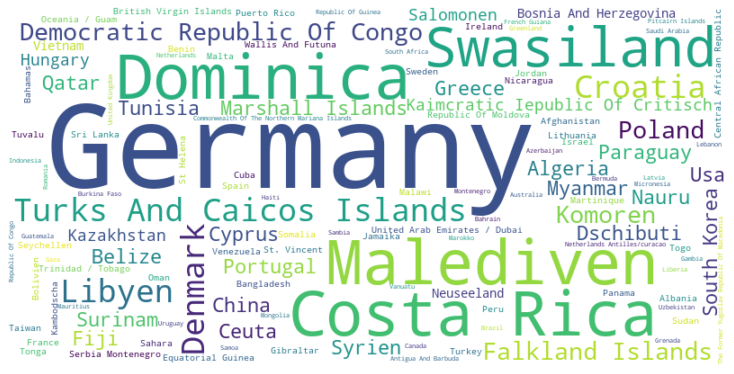

In [15]:
#### task 2 part 1
top_countries_w_years(final_df,"2014-01-01","2020-12-31")

+---------------+-----+
|production_date|count|
+---------------+-----+
|           2011|   53|
|           2012|   47|
|           2017|   43|
|           2015|   42|
|           2016|   37|
|           2013|   37|
|           2019|   34|
|           2018|   31|
|           2014|   31|
|           2020|   26|
|           2021|   17|
+---------------+-----+

Total number of units sold in each year


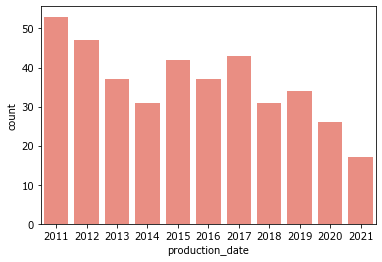

In [16]:
#### task 2 part 2
vehicles_per_year(final_df)

In [17]:
#### task 2 part 3
first_vehicle(final_df)

fin:'WEB36004609995198' is the first vehicle corresponding to date:'2011-01-26', shipped to 'Chad'


In [18]:
#### task 2 part 4
filter_year_cntry_eng(final_df,s_year="2017-01-01",e_year="2021-01-01")

+-----------------+---------------+--------------------+-----------------+-------------------+
|              fin|production_date|             country|engine_sales_code|Code Description En|
+-----------------+---------------+--------------------+-----------------+-------------------+
|WEB93242568855045|     2019-09-08|             Germany|              Z5B|             OM 934|
|WEB46621125785635|     2018-01-29|              Libyen|              Z5D|             OM 470|
|WEB96465783638934|     2017-03-22|      Oceania / Guam|              Z5C|             OM 936|
|WDB53371429331330|     2017-02-20|              Panama|              Z5D|             OM 470|
|NMB71327410429524|     2019-04-24|Democratic Republ...|              Z5C|             OM 936|
|WEB75879323918209|     2020-01-10|              Greece|              Z5B|             OM 934|
|WDB85824751704234|     2018-09-06|                Oman|              Z5E|             OM 471|
|WEB36127895165833|     2019-04-07|             Ge

In [19]:
#### task 2 part 5
filter_year_cntry_eng(final_df,s_year="2017-01-01",e_year="2021-01-01",country="Neuseeland",eng1="OM 936")

+-----------------+---------------+----------+-----------------+-------------------+
|              fin|production_date|   country|engine_sales_code|Code Description En|
+-----------------+---------------+----------+-----------------+-------------------+
|NMB26186144147288|     2019-06-01|Neuseeland|              Z5C|             OM 936|
+-----------------+---------------+----------+-----------------+-------------------+

1
+----+------+
|Year|OM 936|
+----+------+
|2019|     1|
+----+------+

